## Import statements

In [ ]:
from drizly_dagster_utils.integrations.snowflake import SnowflakeConn
from ds_template_test.util.config import cfg
from ds_template_test.util.data_accessors import snowflake_dataframe_from_sql, snowflake_execute_query

%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
from pandas_profiling import ProfileReport
!jupyter nbextension enable --py widgetsnbextension

## Data Ingestion

In [ ]:
df = snowflake_dataframe_from_sql("Select * FROM stage_js.datascience.store_ratings")

## Data Processing

In [60]:
common_timestamp_columns = ['date', 'created_at','updated_at','dt','timestamp','event_time']
for column in df.columns:
    if column.lower() in common_timestamp_columns:
        print(f"Updating {column} from object to datetime")
        df[column] = pd.to_datetime(df[column])

Updating created_at from object to datetime


## EDA

Basic column information and counts

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3223 entries, 0 to 3222
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   store_id                 3223 non-null   int64  
 1   orders_reporting         3218 non-null   float64
 2   orders_redshift          3218 non-null   float64
 3   ontime_score             3218 non-null   float64
 4   fast_score               3218 non-null   float64
 5   acceptance_time_score    3207 non-null   float64
 6   scheduled_on_time_score  3220 non-null   float64
 7   substitution_score       3218 non-null   float64
 8   total_score              3223 non-null   float64
 9   created_at               3223 non-null   object 
 10  avg_acceptance_time      3207 non-null   float64
 11  avg_rating               3115 non-null   float64
 12  avg_delivery_time        3212 non-null   float64
 13  avg_in_store_time        3199 non-null   float64
 14  ontime_pct              

##### Data profiling
This can be written to disk using the to_file(filename) command or it can be displayed directly

In [75]:
pr = ProfileReport(df, explorative = True)
pr.to_file("00-EDA-template-profile.html")

#### Pairwise analysis

In [ ]:
# Set the default theme for seaborn
sns.set_theme()
sns.pairplot(df[df.columns], hue="total_score")

/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


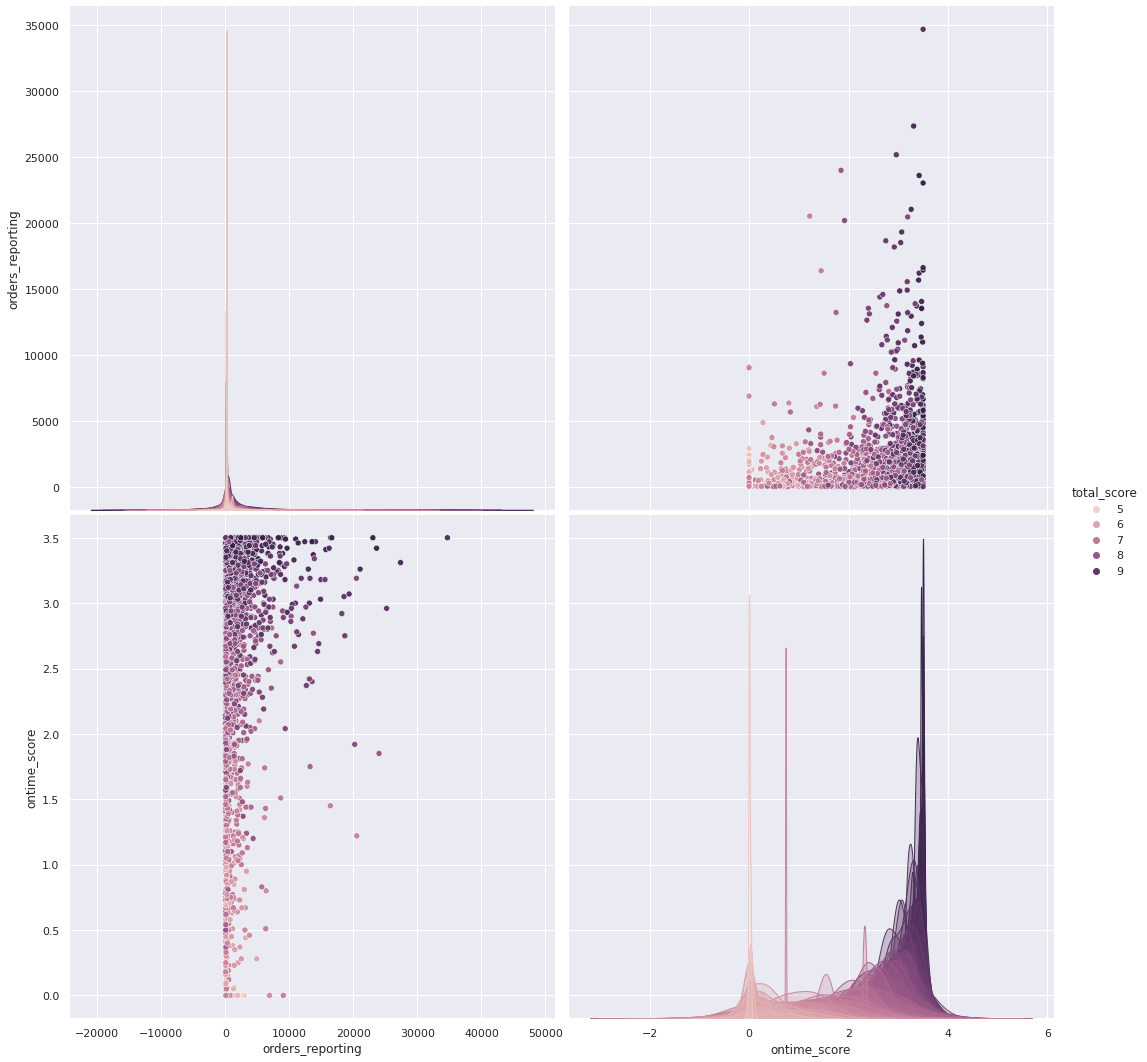

In [80]:
sns.pairplot(df[["orders_reporting","ontime_score", "total_score"]], height=7.5,hue="total_score")